# Recomendador de inversiones inmoviliarias

## Datos origen:

- [Precio_medio_EUR_m2_alquiler](datasets/Precio_medio_EUR_m2_alquiler.csv)
- [Precio_medio_EUR_m2_compraventa](datasets/Precio_medio_EUR_m2_compraventa.csv)
- [BarcelonaCiutat_SeccionsCensals](datasets/BarcelonaCiutat_SeccionsCensals.csv)


## Tareas:

1. Dentificar toda la jerarquia de distritos y barrios
1. Modelo de ML para extrapolar precios estadístico de alquiler y compraventa a fecha de hoy
1. Asignar precio estadístico de alquiler y compraventa a cada inmueble basado en su barrio o distrito
1. Crear una puntuación para cada barrio o distrito de 0 a 1
1. Crear una puntuación para el precio de compra para cada inmueble de 0 a 1 en función del precio estadístico de compra de cada barrio o distrito
1. Crear una puntuación para el precio de alquiler para cada inmueble de 0 a 1 en función del precio estadístico de alquiler de cada barrio o distrito
1. Calcular la tasa de retorno de cada inmueble en función del precio de compra y el precio de alquiler
1. Crear una puntuación final para cada inmueble de 0 a 1 en función de las puntuaciones anteriores


## Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

Renta media mensual por superficie (€/m²) de alquiler de viviendas procedente de la estadística de fianzas del INCASOL. Se puede considerar que esta estadística tiene un carácter censal ya que se basa en el recuento de todos los contratos de alquiler que han depositado la fianza en el Incasòl en el período considerado.

La información de distritos y barrios está elaborada a partir de aquéllos viviendas que se han podido geolocalizar. El total de Barcelona puede no coincidir con la suma de compraventas de los distritos o de los barrios.No se publica la información de los ámbitos de menos de seis contratos registrados.


```python
import requests
import io

url = 'https://portaldades.ajuntament.barcelona.cat/services/backend/rest/statistic/export?id=vysnhrdnae&fileformat=CSV'
headers = {'X-IBM-Client-Id': 'ecde3a3261b6b4ce6ce300f1ba7cf0f5', 'Content-Type': 'application/csv'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    superficies = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    display(superficies)
else:
    print('Error al obtener los datos')
    
```


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Carga de datos de Barcelona Datos con el Precio medio por superficie (€/m²) del alquiler de viviendas por distrito

bcn_alquiler = pd.read_csv('datasets/Precio_medio_EUR_m2_alquiler.csv')
bcn_venta = pd.read_csv('datasets/Precio_medio_EUR_m2_compraventa.csv')
bcn_superficie_venta = pd.read_csv('datasets/Superficie_m2_tipo_compraventa.csv')

# Renombrado de columnas
bcn_alquiler.columns = ['mes', 'nombre', 'orden', 'tipo', 'precio_alquiler']
bcn_venta.columns = ['mes', 'nombre', 'orden', 'tipo', 'precio_venta']
bcn_superficie_venta.columns = ['mes', 'nombre', 'orden', 'tipo', 'uso', 'superficie_venta']

# Conversión de mes a periodo
bcn_alquiler['mes'] = pd.to_datetime(bcn_alquiler['mes'])#.dt.to_period('M')
bcn_venta['mes'] = pd.to_datetime(bcn_venta['mes'])#.dt.to_period('M')
bcn_superficie_venta['mes'] = pd.to_datetime(bcn_venta['mes'])#.dt.to_period('M')

# limpieza de datos anteriores a 2014
# bcn_alquiler = bcn_alquiler[bcn_alquiler['mes'].dt.year >= 2014]
# bcn_venta = bcn_venta[bcn_venta['mes'].dt.year >= 2014]
# bcn_superficie_venta = bcn_superficie_venta[bcn_superficie_venta['mes'].dt.year >= 2014]
bcn_superficie_venta = bcn_superficie_venta[bcn_superficie_venta['uso'] == 'Residencial']

# Eliminación de columnas sobrantes
bcn_alquiler.drop('orden', axis=1, inplace=True)
bcn_venta.drop('orden', axis=1, inplace=True)
bcn_superficie_venta.drop(['orden','uso'], axis=1, inplace=True)

# Calculo de duplicado de fechas a la media de precio
bcn_alquiler = bcn_alquiler.groupby(by=['tipo','nombre','mes'])['precio_alquiler'].mean().reset_index()
bcn_venta = bcn_venta.groupby(by=['tipo','nombre','mes'])['precio_venta'].mean().reset_index()
bcn_superficie_venta = bcn_superficie_venta.groupby(by=['tipo','nombre','mes'])['superficie_venta'].sum().reset_index()

# Unión de las dos tablas
bcn_precios = pd.merge(bcn_alquiler, bcn_venta, on=['tipo','nombre','mes'], how='outer')
bcn_precios = pd.merge(bcn_precios, bcn_superficie_venta, on=['tipo','nombre','mes'], how='outer')
bcn_precios

,tipo,nombre,mes,precio_alquiler,precio_venta,superficie_venta
0,Barri,Baró de Viver,2012-09-01 00:00:00+00:00,NaN,NaN,79.0
1,Barri,Baró de Viver,2013-01-01 00:00:00+00:00,NaN,613.200000,NaN
2,Barri,Baró de Viver,2013-11-01 00:00:00+00:00,NaN,NaN,165.0
3,Barri,Baró de Viver,2014-01-01 00:00:00+00:00,3.92,438.500000,92.0
4,Barri,Baró de Viver,2014-03-01 00:00:00+00:00,NaN,NaN,56.0
...,...,...,...,...,...,...
11281,Municipi,Barcelona,2024-05-01 00:00:00+00:00,NaN,3792.943830,NaN
11282,Municipi,Barcelona,2024-06-01 00:00:00+00:00,NaN,3845.827810,122345.0
11283,Municipi,Barcelona,2024-07-01 00:00:00+00:00,NaN,3835.180837,NaN
11284,Municipi,Barcelona,2024-08-01 00:00:00+00:00,NaN,3832.821747,NaN


In [3]:
# Estandarizar nombres de distriros para facilitar la convinación de campos

import unicodedata
import html

def estandarizar(x):
    """ Estandariza el nombre de un barrio o distrito:
         - Quita entidades HTML y UTF-8
         - Normaliza el texto a forma NFD (descompone caracteres con diacríticos)
         - Filtra caracteres con categoría de diacrítico (Mn)
         - Pasa a minúsculas
         - Reemplaza guiones por espacios
         - Quita espacios dobles
    """
    # Unescape HTML and UTF-8 entities
    x = html.unescape(x)
    # Normalizar el texto a forma NFD (descompone caracteres con diacríticos)
    x = unicodedata.normalize('NFD', x)
    # Filtrar caracteres con categoría de diacrítico (Mn)
    x = ''.join(c for c in x if unicodedata.category(c) != 'Mn')
    return x.split(' - AEI ')[0].replace('-', ' ').replace('  ', ' ').lower()

# Cargar estructura de jerarquica de municipio - distrito - barrio
barrios = pd.read_csv('datasets/BarcelonaCiutat_SeccionsCensals.csv')
barrios = barrios.groupby('nom_barri').min().drop(['codi_seccio_censal','geometria_etrs89','geometria_wgs84','codi_aeb'], axis=1).sort_values(by='codi_barri').reset_index()

bcn_precios[['nombre', 'tipo']] = bcn_precios[['nombre', 'tipo']].applymap(estandarizar)
barrios[['nom_barri', 'nom_districte']] = barrios[['nom_barri', 'nom_districte']].applymap(estandarizar)

# Unir a la tabla de precios la jerarquia de distritos
bcn_precios = pd.merge( bcn_precios, barrios,  left_on='nombre', right_on='nom_barri', how='left').drop('nom_barri', axis=1)

print('bcn_precios no encontrados',bcn_precios[(bcn_precios['tipo'] == 'barri') & bcn_precios['nom_districte'].isna()]['nombre'].count())

bcn_precios = bcn_precios.sort_values(by=['tipo', 'nombre', 'mes'], ascending=[True, True, True])



bcn_precios

bcn_precios no encontrados 0


,tipo,nombre,mes,precio_alquiler,precio_venta,superficie_venta,codi_districte,nom_districte,codi_barri
0,barri,baro de viver,2012-09-01 00:00:00+00:00,NaN,NaN,79.0,9.0,sant andreu,58.0
1,barri,baro de viver,2013-01-01 00:00:00+00:00,NaN,613.200000,NaN,9.0,sant andreu,58.0
2,barri,baro de viver,2013-11-01 00:00:00+00:00,NaN,NaN,165.0,9.0,sant andreu,58.0
3,barri,baro de viver,2014-01-01 00:00:00+00:00,3.92,438.500000,92.0,9.0,sant andreu,58.0
4,barri,baro de viver,2014-03-01 00:00:00+00:00,NaN,NaN,56.0,9.0,sant andreu,58.0
...,...,...,...,...,...,...,...,...,...
11281,municipi,barcelona,2024-05-01 00:00:00+00:00,NaN,3792.943830,NaN,NaN,NaN,NaN
11282,municipi,barcelona,2024-06-01 00:00:00+00:00,NaN,3845.827810,122345.0,NaN,NaN,NaN
11283,municipi,barcelona,2024-07-01 00:00:00+00:00,NaN,3835.180837,NaN,NaN,NaN,NaN
11284,municipi,barcelona,2024-08-01 00:00:00+00:00,NaN,3832.821747,NaN,NaN,NaN,NaN


In [4]:

# Rename columns
bcn_precios = bcn_precios.rename(columns={
    'codi_districte': 'sup_id',
    'nom_districte': 'sup_nombre', 
    'codi_barri': 'id'
})

# Reordenar columnas
bcn_precios = bcn_precios[['id', 'nombre', 'sup_id', 'sup_nombre', 'tipo', 'mes', 'precio_alquiler', 'precio_venta', 'superficie_venta']].sort_values(by=['id', 'tipo', 'mes'], ascending=[True, True, True])

# Convert id column to integer, replacing NaN with -1 first
bcn_precios[['id', 'sup_id']] = bcn_precios[['id', 'sup_id']].fillna(-1).astype(int)

bcn_precios[bcn_precios['id'] == 9].sort_values(by=['nombre'], ascending=[True])

,id,nombre,sup_id,sup_nombre,tipo,mes,precio_alquiler,precio_venta,superficie_venta
7152,9,la nova esquerra de l'eixample,2,eixample,barri,2012-01-01 00:00:00+00:00,NaN,2753.459341,603.0
7249,9,la nova esquerra de l'eixample,2,eixample,barri,2020-03-01 00:00:00+00:00,NaN,3943.096774,NaN
7250,9,la nova esquerra de l'eixample,2,eixample,barri,2020-04-01 00:00:00+00:00,14.279763,4394.727273,NaN
7251,9,la nova esquerra de l'eixample,2,eixample,barri,2020-05-01 00:00:00+00:00,NaN,3910.454545,NaN
7252,9,la nova esquerra de l'eixample,2,eixample,barri,2020-06-01 00:00:00+00:00,NaN,3210.608696,NaN
...,...,...,...,...,...,...,...,...,...
7204,9,la nova esquerra de l'eixample,2,eixample,barri,2016-06-01 00:00:00+00:00,NaN,3406.554054,NaN
7205,9,la nova esquerra de l'eixample,2,eixample,barri,2016-07-01 00:00:00+00:00,12.485235,3158.690909,4245.0
7206,9,la nova esquerra de l'eixample,2,eixample,barri,2016-08-01 00:00:00+00:00,NaN,2789.437500,NaN
7199,9,la nova esquerra de l'eixample,2,eixample,barri,2016-01-01 00:00:00+00:00,11.942033,3278.732115,NaN


In [5]:
def fill_district(df):
    """
    Fill district information for records of type 'districte' in the dataframe.
    
    This function updates the id, sup_id and sup_nombre columns for district records
    by matching them with the barrios dataframe. The id is set to 8000 + district code,
    sup_id is set to 8000, and sup_nombre is set to 'barcelona'.

    Args:
        df (pd.DataFrame): Dataframe containing real estate price data with columns:
            - tipo: Type of record ('districte', 'municipi', 'barri')
            - nombre: Name of the district/neighborhood
            - id: Identifier 
            - sup_id: Parent identifier
            - sup_nombre: Parent name

    Returns:
        None. The dataframe is modified in-place.
    """
    # Filter records of type "Districte"
    df_districte = df[df['tipo'] == 'districte']

    # Update id, sup_id and sup_nombre columns
    for index, row in df_districte.iterrows():
        match = barrios[barrios['nom_districte'] == row['nombre']]
        if not match.empty:
            df.at[index, 'id'] = (800 + match.iloc[0]['codi_districte']) * 100
            df.at[index, 'sup_id'] = 80000
            df.at[index, 'sup_nombre'] = 'barcelona'

# Fill district information
fill_district(bcn_precios)

# Update neighborhood parent ids by adding 8000 offset
bcn_precios.loc[bcn_precios.tipo == 'barri','sup_id'] = (bcn_precios.loc[bcn_precios.tipo == 'barri','sup_id'] + 800) * 100
bcn_precios.loc[bcn_precios.tipo == 'barri','id'] = bcn_precios.loc[bcn_precios.tipo == 'barri','sup_id'] + bcn_precios.loc[bcn_precios.tipo == 'barri','id']

# Set municipality level identifiers
bcn_precios.loc[bcn_precios.tipo == 'municipi',['id','sup_id','sup_nombre']] = [80000,800000,'barcelones']



# Return filtered view of neighborhoods
bcn_precios[bcn_precios['tipo'] == 'districte']


,id,nombre,sup_id,sup_nombre,tipo,mes,precio_alquiler,precio_venta,superficie_venta
9882,80400,les corts,80000,barcelona,districte,2000-01-01 00:00:00+00:00,7.252598,NaN,NaN
9883,80400,les corts,80000,barcelona,districte,2000-04-01 00:00:00+00:00,7.384177,NaN,NaN
9884,80400,les corts,80000,barcelona,districte,2000-07-01 00:00:00+00:00,7.913389,NaN,NaN
9885,80400,les corts,80000,barcelona,districte,2000-10-01 00:00:00+00:00,8.248708,NaN,NaN
9886,80400,les corts,80000,barcelona,districte,2001-01-01 00:00:00+00:00,8.440880,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9881,80700,horta guinardo,80000,barcelona,districte,2024-09-01 00:00:00+00:00,NaN,3155.152174,NaN
10282,80800,nou barris,80000,barcelona,districte,2024-09-01 00:00:00+00:00,NaN,2414.818182,3786.0
10683,81000,sant marti,80000,barcelona,districte,2024-09-01 00:00:00+00:00,NaN,3734.583333,NaN
10884,80300,sants montjuic,80000,barcelona,districte,2024-09-01 00:00:00+00:00,NaN,3325.000000,NaN


In [6]:

# Save processed dataframes to CSV
bcn_precios['mes'] = bcn_precios['mes'].dt.strftime('%Y-%m-%d')
bcn_precios[['precio_venta', 'superficie_venta']] = bcn_precios[['precio_venta', 'superficie_venta']].round(0).astype('Int64')
bcn_precios[['precio_alquiler']] = bcn_precios[['precio_alquiler']].round(2)
bcn_precios.sort_values(by=['tipo','id'], ascending=[True, True]).to_csv('datasets/gen_precios.csv', index=False)


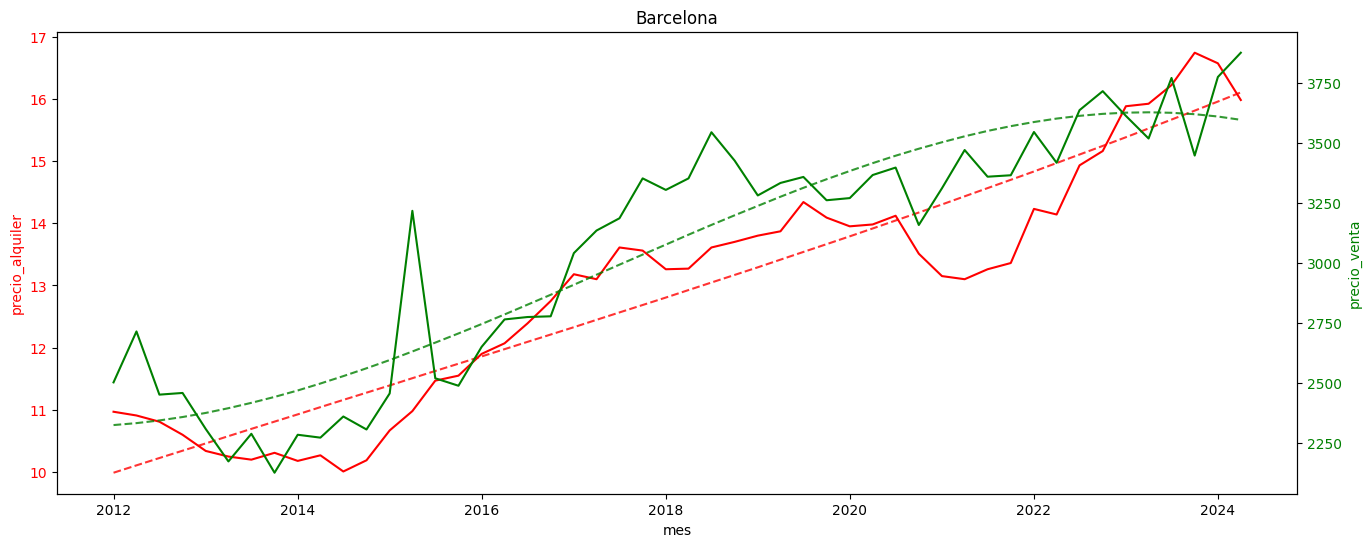

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dual_axis(df, x_col, y1_col, y2_col, title):
    """
    Creates a dual-axis plot showing two time series with trend lines.

    Parameters:
    -----------
    df : pandas.DataFrame
        The dataframe containing the data to plot
    x_col : str
        Name of the column to use for x-axis (typically dates)
    y1_col : str 
        Name of the column to plot on first y-axis
    y2_col : str
        Name of the column to plot on second y-axis
    title : str
        Title for the plot

    Returns:
    --------
    None
        Displays the plot with two y-axes showing both time series and their trend lines
    """
    # Define colors
    COLOR_LINE_1 = "red"
    COLOR_LINE_2 = "green"

    # Ensure data is sorted by date
    df = df.sort_values(by=x_col)
    
    # Drop rows where either y-column is NaN
    df_clean = df.dropna(subset=[y1_col, y2_col])
    
    if len(df_clean) == 0:
        print("No valid data points found after cleaning")
        return
        
    # Create figure and axes
    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Plot first line
    sns.lineplot(data=df_clean, x=x_col, y=y1_col, ax=ax1, color=COLOR_LINE_1, label=y1_col)
    ax1.set_ylabel(y1_col, color=COLOR_LINE_1)
    ax1.tick_params(axis="y", labelcolor=COLOR_LINE_1)

    # Plot second line
    ax2 = ax1.twinx()
    sns.lineplot(data=df_clean, x=x_col, y=y2_col, ax=ax2, color=COLOR_LINE_2, label=y2_col)
    ax2.set_ylabel(y2_col, color=COLOR_LINE_2)
    ax2.tick_params(axis="y", labelcolor=COLOR_LINE_2)

    # Add title and labels
    ax1.set_title(title)
    ax1.set_xlabel(x_col)
    
    # Calculate trend lines using clean data
    x_nums = np.arange(len(df_clean))
    
    # Trend line for first axis
    z1 = np.polyfit(x_nums, df_clean[y1_col], 3)
    p1 = np.poly1d(z1)
    ax1.plot(df_clean[x_col], p1(x_nums), COLOR_LINE_1, linestyle='--', alpha=0.8, label=f"Tendencia {y1_col}")

    # Trend line for second axis
    z2 = np.polyfit(x_nums, df_clean[y2_col], 3)
    p2 = np.poly1d(z2)
    ax2.plot(df_clean[x_col], p2(x_nums), COLOR_LINE_2, linestyle='--', alpha=0.8, label=f"Tendencia {y2_col}")

    # Adjust legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    ax1.get_legend().remove()
    # Hide legend
    ax2.get_legend().remove()

    # Hide grid
    ax1.grid(False)
    ax2.grid(False)

    plt.show()

bcn_precios['mes'] = pd.to_datetime(bcn_precios['mes'])
plot_dual_axis(bcn_precios[bcn_precios['nombre'] == 'barcelona'], 'mes', 'precio_alquiler', 'precio_venta', 'Barcelona')
